# Process with Spark

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/home/shekhar/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:87: DeprecationWarning: InlineBackend._figure_format_changed is deprecated: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):
/home/shekhar/anaconda3/lib/python3.5/site-packages/ipykernel/pylab/config.py:78: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [17]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn

import numpy as np
import pyspark.sql.functions as func

In [3]:
# seaborn.set_style("whitegrid")

In [4]:
df = spark.read.load('/data4/parquet/citibike.parquet')
df = df.repartition(50, "start_station_id")
df = df.sortWithinPartitions("start_time")
df.write.parquet('/data4/parquet_spark/citibike.parquet', mode='overwrite', compression="snappy")
df.write.orc('/data4/orc/citibike.orc', mode='overwrite', compression="snappy")

In [5]:
for x in ("start_station_name", "start_station_latitude", "start_station_longitude",
        "end_station_name", "end_station_latitude", "end_station_longitude"
       ):
    df = df.drop(x)
df.show(10)

+-------------+----------+----------+----------------+--------------+-------+------------+----------+------+
|trip_duration|start_time| stop_time|start_station_id|end_station_id|bike_id|   user_type|birth_year|gender|
+-------------+----------+----------+----------------+--------------+-------+------------+----------+------+
|        27803|1372639544|1372667347|             229|           509|  17946|"Subscriber"|    1980.0|     1|
|          492|1372640314|1372640806|             168|           512|  17493|"Subscriber"|    1982.0|     2|
|          855|1372641335|1372642190|             307|           450|  19986|  "Customer"|       NaN|     0|
|          530|1372643637|1372644167|             229|           285|  19793|"Subscriber"|    1951.0|     1|
|          436|1372648034|1372648470|             307|           386|  18314|"Subscriber"|    1982.0|     2|
|          983|1372650279|1372651262|             326|           326|  20151|"Subscriber"|    1988.0|     2|
|          942|1372

In [6]:
df = df.repartition("start_station_id")
df = df.sortWithinPartitions("start_time")

In [7]:
df.printSchema()

root
 |-- trip_duration: integer (nullable = true)
 |-- start_time: long (nullable = true)
 |-- stop_time: long (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- bike_id: integer (nullable = true)
 |-- user_type: string (nullable = true)
 |-- birth_year: float (nullable = true)
 |-- gender: integer (nullable = true)



In [8]:
df = df.withColumn("start_time_", func.to_utc_timestamp(func.from_unixtime(df.start_time), "UTC"))
df = df.withColumn("stop_time_", func.to_utc_timestamp(func.from_unixtime(df.stop_time), "UTC"))
df.persist()

/home/shekhar/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/shekhar/anaconda3/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


DataFrame[trip_duration: int, start_time: bigint, stop_time: bigint, start_station_id: int, end_station_id: int, bike_id: int, user_type: string, birth_year: float, gender: int, start_time_: timestamp, stop_time_: timestamp]

In [9]:
df.createOrReplaceTempView("bike")

In [13]:
z = spark.sql('''SELECT round(float((hour(start_time_)*60+minute(start_time_)+hour(start_time_)/60.0)/15.0))/4.0
              as start_time from 
              bike where start_station_id=302''')
z2 = spark.sql('''SELECT round(float((hour(start_time_)*60+minute(start_time_)+hour(start_time_)/60.0)/15.0))/4.0
              as start_time from 
              bike where start_station_id=442''')
z3 = spark.sql('''SELECT round(float((hour(start_time_)*60+minute(start_time_)+hour(start_time_)/60.0)/15.0))/4.0
              as start_time from 
              bike''')

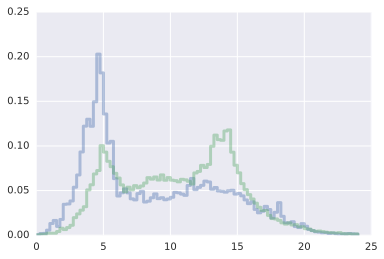

In [35]:
seaborn.distplot(z.toPandas().start_time.values, bins=np.arange(0, 24.01, 0.25), kde=False,
                 hist_kws=dict(histtype='step', linewidth=3, normed=True),)
seaborn.distplot(z2.toPandas().start_time.values, bins=np.arange(0, 24.01, 0.25), kde=False,
                 hist_kws=dict(histtype='step', linewidth=3, normed=True),)

In [ ]:
seaborn.distplot(z3.toPandas().start_time.values, bins=np.arange(0, 24.01, 0.25), kde=False,
                 hist_kws=dict(histtype='step', linewidth=3), hist=True)

# Process with Dask

In [22]:
import dask.dataframe as dd

In [28]:
df2 = dd.read_parquet('/data4/parquet/citibike.parquet')

In [32]:
df2['start_time'] = (df2['start_time']*1e9).astype('datetime64')

/home/shekhar/anaconda3/lib/python3.5/site-packages/dask/dataframe/utils.py:414: DeprecationWarning: pandas.core.common.is_datetime64tz_dtype is deprecated. import from the public API: pandas.api.types.is_datetime64tz_dtype instead
  return _nonempty_series(x, idx)


In [34]:
df2[['start_time']].head()

SystemError: <built-in function cast_to_nanoseconds> returned a result with an error set

Traceback
---------
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/dask/async.py", line 266, in execute_task
    result = _execute_task(task, data)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/dask/async.py", line 247, in _execute_task
    return func(*args2)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/dask/dataframe/core.py", line 3077, in apply_and_enforce
    df = func(*args, **kwargs)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/dask/utils.py", line 935, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py", line 3054, in astype
    raise_on_error=raise_on_error, **kwargs)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/internals.py", line 3189, in astype
    return self.apply('astype', dtype=dtype, **kwargs)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/internals.py", line 3056, in apply
    applied = getattr(b, f)(**kwargs)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/internals.py", line 461, in astype
    values=values, **kwargs)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/internals.py", line 508, in _astype
    klass=klass)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/internals.py", line 2685, in make_block
    return klass(values, ndim=ndim, fastpath=fastpath, placement=placement)
  File "/home/shekhar/anaconda3/lib/python3.5/site-packages/pandas/core/internals.py", line 2188, in __init__
    values = tslib.cast_to_nanoseconds(values)
